# Kaggle Competition: Mercedes-Benz Greener Manufacturing

The goal of this project is to use random search to build a feed-forward neural network that can score well in Kaggle's Mercedes-Benz Greener Manufacturing competition. The network will be built using TensorFlow. Many features of the network will be experimented with including the number of layers, nodes per layer, activation functions, etc. to find a network that can perform well. The best performing networks will have their predictions averaged, which will act like a "wisdom of crowd" method. 

I have never built a neural network with this amount of experimentation, so I thought using a Kaggle competition could provide a good benchmark for its performance. Also, in the past I have focused more towards using grid search, but it should be interesting to see how well things perform here with random search.

You can learn more about this competition on [Kaggle's website](https://www.kaggle.com/c/mercedes-benz-greener-manufacturing).

The sections of this project are:
- Loading the Data
- Preparing the Data
- Building the Network
- Training the Network
- Making Predictions
- Summary

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.python.framework import ops
from tensorflow.python.framework import tensor_shape
from tensorflow.python.framework import tensor_util
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import random_ops
from tensorflow.python.ops import array_ops
from tensorflow.python.layers import utils
from collections import namedtuple

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
import time
import operator 

print(tf.__version__)

1.2.1


## Loading the Data

In [107]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [108]:
train.head()

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,...,0,0,0,0,0,0,0,0,0,0


In [109]:
test.head()

,ID,X0,X1,X2,X3,X4,X5,X6,X8,X10,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,1,az,v,n,f,d,t,a,w,0,...,0,0,0,1,0,0,0,0,0,0
1,2,t,b,ai,a,d,b,g,y,0,...,0,0,1,0,0,0,0,0,0,0
2,3,az,v,as,f,d,a,j,j,0,...,0,0,0,1,0,0,0,0,0,0
3,4,az,l,n,f,d,z,l,n,0,...,0,0,0,1,0,0,0,0,0,0
4,5,w,s,as,c,d,y,i,m,0,...,1,0,0,0,0,0,0,0,0,0


In [110]:
print(train.shape)
print(test.shape)

(4209, 378)
(4209, 377)


In [111]:
train.describe()

,ID,y,X10,X11,X12,X13,X14,X15,X16,X17,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
count,4209.000000,4209.000000,4209.000000,4209.0,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,...,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000
mean,4205.960798,100.669318,0.013305,0.0,0.075077,0.057971,0.428130,0.000475,0.002613,0.007603,...,0.318841,0.057258,0.314802,0.020670,0.009503,0.008078,0.007603,0.001663,0.000475,0.001426
std,2437.608688,12.679381,0.114590,0.0,0.263547,0.233716,0.494867,0.021796,0.051061,0.086872,...,0.466082,0.232363,0.464492,0.142294,0.097033,0.089524,0.086872,0.040752,0.021796,0.037734
min,0.000000,72.110000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2095.000000,90.820000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4220.000000,99.150000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6314.000000,109.010000,0.000000,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,8417.000000,265.320000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [112]:
# If any feature has the same value in each row, it is considered an unhelpful feature.
unhelpful_features = []
for feature in train:
    if max(train[feature]) == min(train[feature]):
        print(feature)
        unhelpful_features.append(feature)

X11
X93
X107
X233
X235
X268
X289
X290
X293
X297
X330
X347


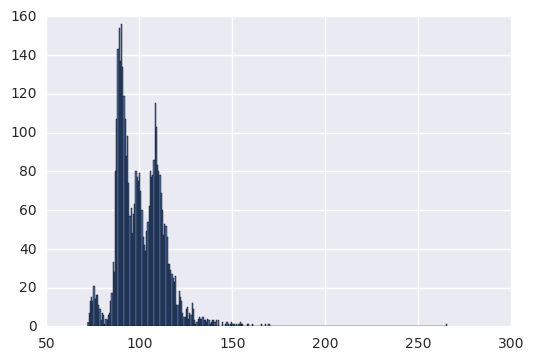

In [113]:
# To detect any outliers, plot the y values.
plt.hist(train.y, bins = 300)
plt.show()

In [115]:
# Only one outlier.
train[train.y >= 170]

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
883,1770,265.32,y,r,ai,f,d,ag,l,t,...,0,0,0,0,0,0,0,0,0,0


## Preparing the Data

In [10]:
# Drop the outlier
train = train[train.y < 170]

# Remove y from dataframe
y = train.y
train = train.drop('y',1)

# Concatenate the training and testing dataframe
df = pd.concat([train,test])

# Drop unhelpful features
df = df.drop(unhelpful_features,1)

In [11]:
df.shape

(8417, 365)

In [12]:
# Find the categorical features, which will need to be converted into dummy features.
dummies = []
for column in df:
    if max(df[column]) != 1:
        print(column)
        dummies.append(column)
print(dummies)

ID
X0
X1
X2
X3
X4
X5
X6
X8
['ID', 'X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X8']


In [13]:
# ID should be removed since it will not be used during training.
dummies = dummies[1:]

In [14]:
# Add dummy features, remove the original, and remove ID from the dataframe.
for feature in dummies:
    dummy_features = pd.get_dummies(df[feature], prefix=feature)
    for dummy in dummy_features:
        df[dummy] = dummy_features[dummy]
    df = df.drop([feature], 1)
df = df.drop(['ID'],1)

In [15]:
# Check the number of new features
df.shape

(8417, 567)

In [16]:
df.head()

,X10,X12,X13,X14,X15,X16,X17,X18,X19,X20,...,X8_p,X8_q,X8_r,X8_s,X8_t,X8_u,X8_v,X8_w,X8_x,X8_y
0,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
# Split dataframe into training and testing sets
trainFinal = df[:len(train)]
testFinal = df[len(train):]
yFinal = pd.DataFrame(y)

## Build the Network

In [18]:
def create_weights_biases(num_layers, n_inputs, multiplier, max_nodes):
    '''Use the inputs to create the weights and biases for a network'''
    
    # Empty dictionaries to store the weights and biases for each layer
    weights = {}
    biases = {}
    
    # Create weights and biases for all layers, but the final layer
    for layer in range(1,num_layers):
        # The first layer needs to use the number of features that are in the dataframe
        if layer == 1:
            weights["h"+str(layer)] = tf.Variable(tf.random_normal([num_features, n_inputs],
                                                                   stddev=np.sqrt(1/num_features)))
            biases["b"+str(layer)] = tf.Variable(tf.random_normal([n_inputs],stddev=0))
            # n_previous keeps track of the number of nodes in the previous layer
            n_previous = n_inputs
            
        else:    
            # To alter number of nodes in each layer, multiply n_previous by multiplier 
            n_current = int(n_previous * multiplier)
            
            # Limit the number of nodes to the maximum amount
            if n_current >= max_nodes:
                n_current = max_nodes
                
            weights["h"+str(layer)] = tf.Variable(tf.random_normal([n_previous, n_current],
                                                                       stddev=np.sqrt(1/n_previous)))
            biases["b"+str(layer)] = tf.Variable(tf.random_normal([n_current],stddev=0))
            n_previous = n_current
            
    # Create weights for the final layer
    n_current = int(n_previous * multiplier)
    if n_current >= max_nodes:
        n_current = max_nodes
            
    # The final layer only has 1 node since this is a regression task
    weights["out"] = tf.Variable(tf.random_normal([n_previous, 1], stddev=np.sqrt(1/n_previous)))
    biases["out"] = tf.Variable(tf.random_normal([1],stddev=0))
                                                    
    return weights, biases

In [19]:
def network(num_layers, n_inputs, weights, biases, rate, is_training, activation_function):
    '''Add the required number of layers to the network'''
    
    for layer in range(1, num_layers):
        if layer == 1:
            current_layer = eval(activation_function + "(tf.matmul(n_inputs, weights['h1']) + biases['b1'])")
            current_layer = tf.nn.dropout(current_layer, 1-rate)
            previous_layer = current_layer
        else:
            current_layer = eval(activation_function + "(tf.matmul(previous_layer,\
            weights['h'+str(layer)]) + biases['b'+str(layer)])")
            current_layer = tf.nn.dropout(current_layer, 1-rate)
            previous_layer = current_layer

    # Output layer with linear activation - because regression
    out_layer = tf.matmul(previous_layer, weights['out']) + biases['out']
    return out_layer

In [20]:
def model_inputs():
    '''Create placeholders for model's inputs '''
    
    inputs = tf.placeholder(tf.float32, [None, None], name='inputs')
    targets = tf.placeholder(tf.float32, [None, 1], name='targets')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    dropout_rate = tf.placeholder(tf.float32, name='dropout_rate')
    is_training = tf.placeholder(tf.bool, name='is_training')
    
    return inputs, targets, learning_rate, dropout_rate, is_training

In [21]:
def build_graph(num_layers,n_inputs,weights_multiplier,dropout_rate,learning_rate,max_nodes,activation_function):
    '''Use inputs to build the graph and export the required features for training'''
    
    # Reset the graph to ensure it is ready for training
    tf.reset_default_graph()
    
    # Get the inputs
    inputs, targets, learning_rate, dropout_rate, is_training = model_inputs()
    
    # Get the weights and biases
    weights, biases = create_weights_biases(num_layers, n_inputs, weights_multiplier, max_nodes)
    
    # Construct the network
    preds = network(num_layers, inputs, weights, biases, dropout_rate, is_training, activation_function)    
            
    with tf.name_scope("cost"):
        # Cost function
        cost = tf.losses.mean_squared_error(labels=targets, predictions=preds)
        tf.summary.scalar('cost', cost)

    with tf.name_scope("optimze"):
        optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

    # Merge all of the summaries
    merged = tf.summary.merge_all()    

    # Export the nodes 
    export_nodes = ['inputs','targets','dropout_rate','is_training','cost','preds','merged',
                    'optimizer','learning_rate']
    Graph = namedtuple('Graph', export_nodes)
    local_dict = locals()
    graph = Graph(*[local_dict[each] for each in export_nodes])

    return graph

## Training the Network

In [22]:
def train(model, epochs, log_string, learning_rate):
    '''Train the Network and return the average MSE for each iteration of the model'''
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())

        # Used to determine when to stop the training early
        testing_loss_summary = []

        iteration = 0 # Keep track of which batch iteration is being trained
        stop_early = 0 # Keep track of how many consective epochs have not achieved a record low MSE
        stop = 10 # If the batch_loss_testing does not decrease in 10 consecutive epochs, stop training
        
        # Decay learning rate after consective epochs of no improvements
        learning_rate_decay_threshold = np.random.choice([2,3,4,5]) 
        n_splits = 5 # Number of KFold splits
        original_learning_rate = learning_rate # Keep track of orginial learning rate for each split

        print()
        print("Training Model: {}".format(log_string))

        # Record progress to view with TensorBoard
        train_writer = tf.summary.FileWriter('./logs/1/train/{}'.format(log_string), sess.graph)
        test_writer = tf.summary.FileWriter('./logs/1/test/{}'.format(log_string))

        # Split the data into the number of folds (n_splits)
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=2)
        split = 0 # Keeps track of the current fold
        sum_loss_testing = 0 # Keeps track of the total loss
        
        for train_index, test_index in kf.split(trainFinal): 
            
            # Split data into training and testing sets
            x_train = trainFinal.iloc[train_index]
            y_train = yFinal.iloc[train_index]
            x_test = trainFinal.iloc[test_index]
            y_test = yFinal.iloc[test_index]
            
            training_check = (len(x_train)//batch_size)-1 # Check training progress after this many batches
            testing_check = training_check # Check testing results
            
            split += 1
            print('Start KFold number {} from {}'.format(split, n_splits))
        
            for epoch_i in range(1, epochs+1): 
                batch_loss = 0
                batch_time = 0

                for batch in range(int(len(x_train)/batch_size)):
                    batch_x = x_train[batch*batch_size:(1+batch)*batch_size]
                    batch_y = y_train[batch*batch_size:(1+batch)*batch_size]

                    start_time = time.time()

                    summary, loss, _ = sess.run([model.merged,
                                                 model.cost, 
                                                 model.optimizer], 
                                                 {model.inputs: batch_x,
                                                  model.targets: batch_y,
                                                  model.learning_rate: learning_rate,
                                                  model.dropout_rate: dropout_rate,
                                                  model.is_training: True})


                    batch_loss += loss
                    end_time = time.time()
                    batch_time += end_time - start_time

                    # Record the progress of training
                    train_writer.add_summary(summary, iteration)

                    iteration += 1

                    if batch % training_check == 0 and batch > 0:
                        print('Epoch {:>3}/{} Batch {:>4}/{} - MSE: {:>6.3f}, Seconds: {:>4.2f}'
                              .format(epoch_i,
                                      epochs, 
                                      batch, 
                                      len(x_train) // batch_size, 
                                      (batch_loss / training_check), 
                                      batch_time))
                        batch_loss = 0
                        batch_time = 0

                    #### Testing ####
                    if batch % testing_check == 0 and batch > 0:
                        batch_loss_testing = 0
                        batch_time_testing = 0
                        for batch in range(int(len(x_test)/batch_size)):
                            batch_x = x_test[batch*batch_size:(1+batch)*batch_size]
                            batch_y = y_test[batch*batch_size:(1+batch)*batch_size]
                            
                            start_time_testing = time.time()
                            summary, loss = sess.run([model.merged,
                                                      model.cost], 
                                                         {model.inputs: batch_x,
                                                          model.targets: batch_y,
                                                          model.learning_rate: learning_rate,
                                                          model.dropout_rate: 0,
                                                          model.is_training: False})

                            batch_loss_testing += loss
                            end_time_testing = time.time()
                            batch_time_testing += end_time_testing - start_time_testing

                            # Record the progress of testing
                            test_writer.add_summary(summary, iteration)

                        n_batches_testing = batch + 1
                        print('Testing MSE: {:>6.3f}, Seconds: {:>4.2f}'
                              .format(batch_loss_testing / n_batches_testing, 
                                      batch_time_testing))

                        batch_time_testing = 0

                        # If the batch_loss_testing is at a new minimum, save the model
                        testing_loss_summary.append(batch_loss_testing)
                        if batch_loss_testing <= min(testing_loss_summary):
                            print('New Record!') 
                            lowest_loss_testing = batch_loss_testing/n_batches_testing
                            stop_early = 0 # Reset stop_early if new minimum loss is found
                            checkpoint = "./{}.ckpt".format(log_string)
                            saver = tf.train.Saver()
                            saver.save(sess, checkpoint)

                        else:
                            print("No Improvement.")
                            stop_early += 1 # Increase stop_early if no new minimum loss is found
                            if stop_early % learning_rate_decay_threshold == 0:
                                learning_rate *= learning_rate_decay
                                print("New learning rate = ", learning_rate)
                            elif stop_early == stop:
                                break
                
                if stop_early == stop:
                    print("Stopping training for this fold.")
                    print("Lowest MSE =", lowest_loss_testing)
                    print()
                    sum_loss_testing += lowest_loss_testing
                    early_stop = 0
                    testing_loss_summary = []
                    learning_rate = original_learning_rate
                    break
            
        # Find the average loss of each testing split    
        average_testing_loss = sum_loss_testing/n_splits
        print("Stopping training for this iteration.")
        print("Average MSE for this iteration: ", average_testing_loss)
        print()
        
    return average_testing_loss

In [23]:
# More iterations of the network were used to make my final predictions for the competition (250) and 
# the number of epochs for each split was increased to 250.
# These values were reduced to save time when re-running this notebook.

num_iterations = 25
results = {} # Save the log_string and MSE of each iteration
for i in range(num_iterations):
    # (Randomly) choose the value for each input
    num_features = trainFinal.shape[1]
    epochs = 50
    learning_rate = np.random.uniform(0.001, 0.1)
    learning_rate_decay = np.random.uniform(0.1,0.5)
    weights_multiplier = np.random.uniform(0.5,2)
    n_inputs = np.random.randint(int(num_features)*0.1,int(num_features)*2)
    num_layers = np.random.choice([2,3,4])
    dropout_rate = np.random.uniform(0,0.3)
    batch_size = np.random.choice([64,128,256])
    max_nodes = np.random.choice([32,64,128,256,512,1024,2048,4096])
    activation_function = np.random.choice(['tf.nn.sigmoid',
                                            'tf.nn.relu',
                                            'tf.nn.elu'])

    print("Starting iteration #",i+1)
    log_string = 'LR={},LRD={},WM={},NI={},NL={},DR={},BS={},MN={},AF={}'.format(learning_rate,
                                                                                 learning_rate_decay,
                                                                                 weights_multiplier,
                                                                                 n_inputs,
                                                                                 num_layers,
                                                                                 dropout_rate,
                                                                                 batch_size,
                                                                                 max_nodes,
                                                                                 activation_function) 
    
    model = build_graph(num_layers, n_inputs, weights_multiplier, 
                        dropout_rate,learning_rate,max_nodes,activation_function)
    result = train(model, epochs, log_string, learning_rate)
    results[log_string] = result

Starting iteration # 1

Training Model: LR=0.006542447063356203,LRD=0.14511855947248775,WM=1.2608166600082802,NI=475,NL=2,DR=0.0056114515168893654,BS=256,MN=4096,AF=tf.nn.elu
Start KFold number 1 from 5
Epoch   1/50 Batch   12/13 - MSE: 4106.838, Seconds: 0.21
Testing MSE: 1317.368, Seconds: 0.03
New Record!
Epoch   2/50 Batch   12/13 - MSE: 685.027, Seconds: 0.23
Testing MSE: 466.008, Seconds: 0.03
New Record!
Epoch   3/50 Batch   12/13 - MSE: 298.209, Seconds: 0.20
Testing MSE: 186.628, Seconds: 0.02
New Record!
Epoch   4/50 Batch   12/13 - MSE: 142.488, Seconds: 0.30
Testing MSE: 124.596, Seconds: 0.06
New Record!
Epoch   5/50 Batch   12/13 - MSE: 117.838, Seconds: 0.18
Testing MSE: 89.578, Seconds: 0.02
New Record!
Epoch   6/50 Batch   12/13 - MSE: 93.260, Seconds: 0.20
Testing MSE: 79.333, Seconds: 0.02
New Record!
Epoch   7/50 Batch   12/13 - MSE: 88.051, Seconds: 0.20
Testing MSE: 73.440, Seconds: 0.02
New Record!
Epoch   8/50 Batch   12/13 - MSE: 83.149, Seconds: 0.18
Testing M

In [24]:
def find_inputs(model):
    '''Use the log_string from the model to extract the values for all of the model's inputs'''
    
    learning_rate_start = model.find('LR=') + 3
    learning_rate_end = model.find(',LRD', learning_rate_start)
    learning_rate = float(model[learning_rate_start:learning_rate_end])
    
    learning_rate_decay_start = model.find('LRD=') + 4
    learning_rate_decay_end = model.find(',WM', learning_rate_decay_start)
    learning_rate_decay = float(model[learning_rate_decay_start:learning_rate_decay_end])
    
    weights_multiplier_start = model.find('WM=') + 3
    weights_multiplier_end = model.find(',NI', weights_multiplier_start)
    weights_multiplier = float(model[weights_multiplier_start:weights_multiplier_end])
    
    n_inputs_start = model.find('NI=') + 3
    n_inputs_end = model.find(',NL', n_inputs_start)
    n_inputs = int(model[n_inputs_start:n_inputs_end])
    
    num_layers_start = model.find('NL=') + 3
    num_layers_end = model.find(',DR', num_layers_start)
    num_layers = int(model[num_layers_start:num_layers_end])
    
    dropout_rate_start = model.find('DR=') + 3
    dropout_rate_end = model.find(',BS', dropout_rate_start)
    dropout_rate = float(model[dropout_rate_start:dropout_rate_end])
    
    batch_size_start = model.find('BS=') + 3
    batch_size_end = model.find(',MN', batch_size_start)
    batch_size = int(model[batch_size_start:batch_size_end])
    
    max_nodes_start = model.find('MN=') + 3
    max_nodes_end = model.find(',AF', max_nodes_start)
    max_nodes = int(model[max_nodes_start:max_nodes_end])
    
    activation_function_start = model.find('AF=') + 3
    activation_function = str(model[activation_function_start:])
    
    return (learning_rate, learning_rate_decay, weights_multiplier, n_inputs,
            num_layers, dropout_rate, batch_size, max_nodes, activation_function)

In [26]:
# Sort results by MSE (lowest - highest)
sorted_results = sorted(results.items(), key=operator.itemgetter(1))

In [32]:
# Create an empty dataframe to contain all of the inputs for each iteration of the model
results_df = pd.DataFrame(columns=["learning_rate", 
                                   "learning_rate_decay", 
                                   "weights_multiplier", 
                                   "n_inputs",
                                   "num_layers", 
                                   "dropout_rate", 
                                   "batch_size", 
                                   "max_nodes", 
                                   "activation_function"])

for result in sorted_results:
    # Find the input values for each iteration
    learning_rate, learning_rate_decay, weights_multiplier, n_inputs,\
        num_layers, dropout_rate, batch_size, max_nodes, activation_function = find_inputs(result[0])
    
    # Find the Mean Squared Error for each iteration
    MSE = result[1]
    
    # Create a dataframe with the values above
    new_row = pd.DataFrame([[MSE,
                             learning_rate, 
                             learning_rate_decay, 
                             weights_multiplier, 
                             n_inputs,
                             num_layers, 
                             dropout_rate, 
                             batch_size, 
                             max_nodes, 
                             activation_function]],
                     columns = ["MSE",
                                "learning_rate", 
                                "learning_rate_decay", 
                                "weights_multiplier", 
                                "n_inputs",
                                "num_layers", 
                                "dropout_rate", 
                                "batch_size", 
                                "max_nodes", 
                                "activation_function"])
    
    # Append the dataframe as a new row in results_df
    results_df = results_df.append(new_row, ignore_index=True)

In [33]:
# Look at the top five iterations
results_df.head()

,MSE,activation_function,batch_size,dropout_rate,learning_rate,learning_rate_decay,max_nodes,n_inputs,num_layers,weights_multiplier
0,36.614878,tf.nn.relu,128.0,0.054051,0.005840,0.140825,1024.0,430.0,4.0,1.536183
1,41.574443,tf.nn.sigmoid,128.0,0.242760,0.041185,0.214292,2048.0,783.0,2.0,1.906454
2,50.829426,tf.nn.elu,256.0,0.253824,0.006892,0.278109,2048.0,964.0,4.0,0.556530
3,51.408883,tf.nn.elu,256.0,0.042109,0.079792,0.314272,32.0,922.0,3.0,1.450029
4,54.067028,tf.nn.sigmoid,64.0,0.179406,0.097288,0.259985,64.0,466.0,2.0,0.623053


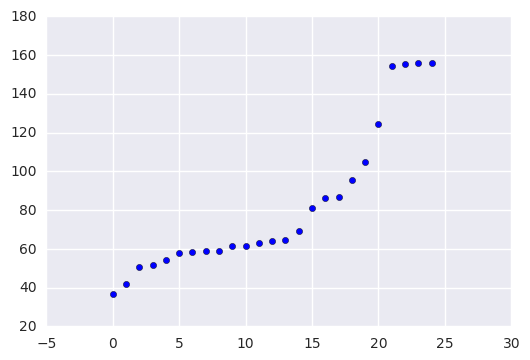

In [57]:
# Plot the MSE
plt.scatter(results_df.index, results_df.MSE)

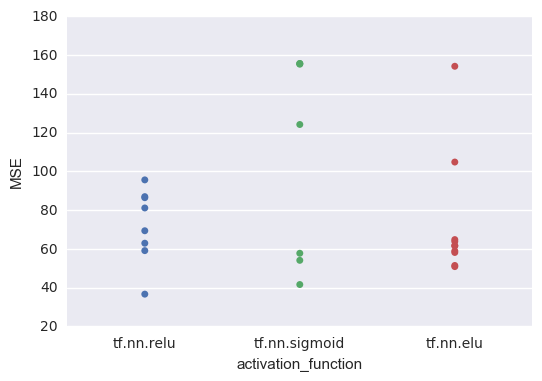

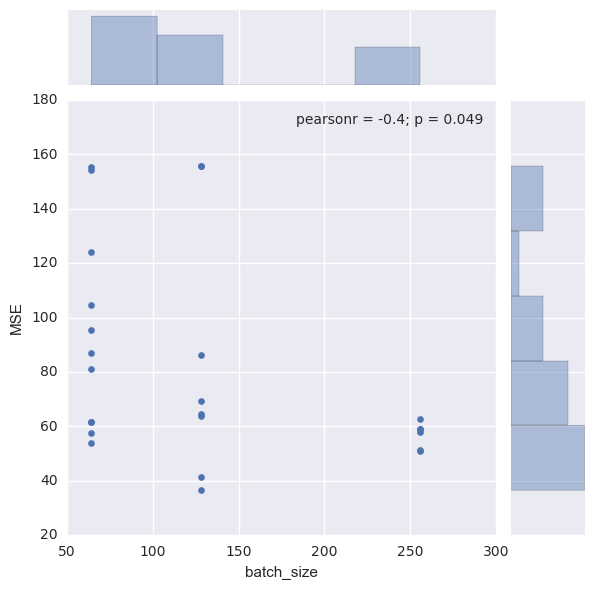

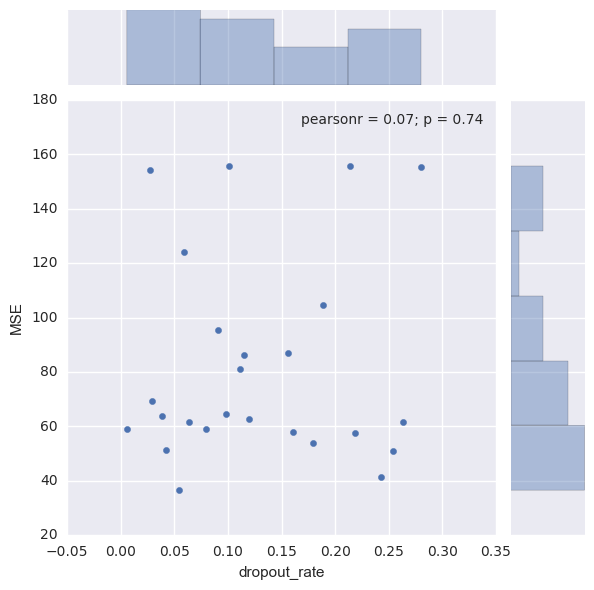

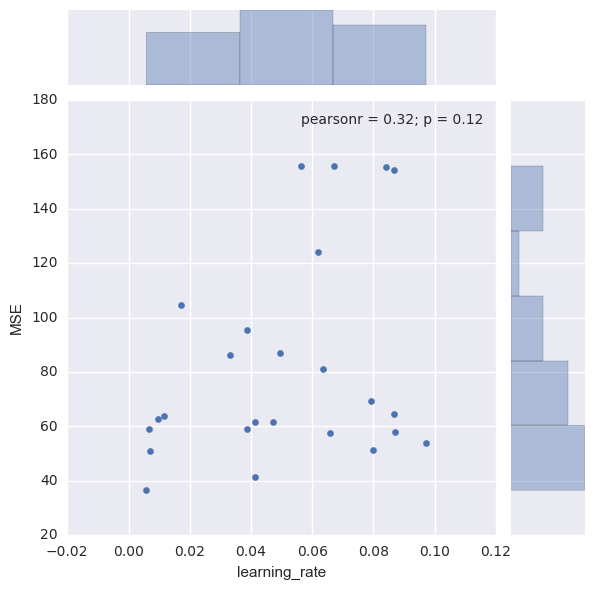

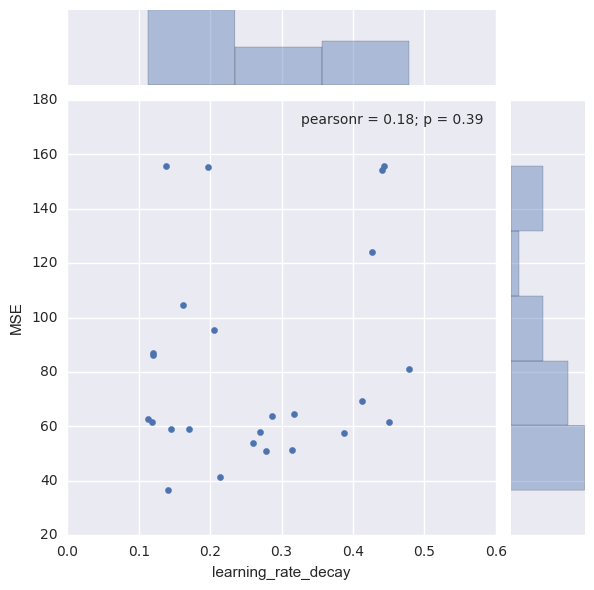

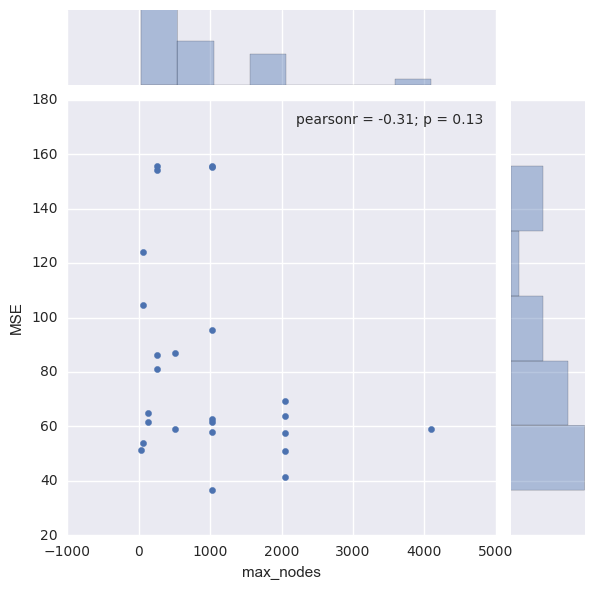

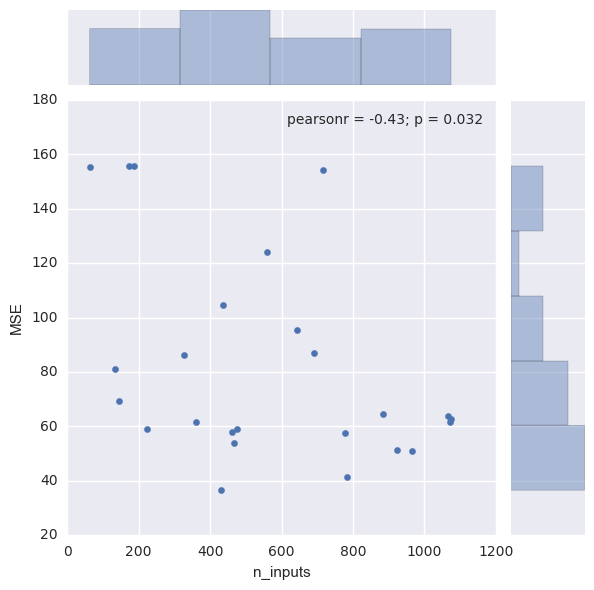

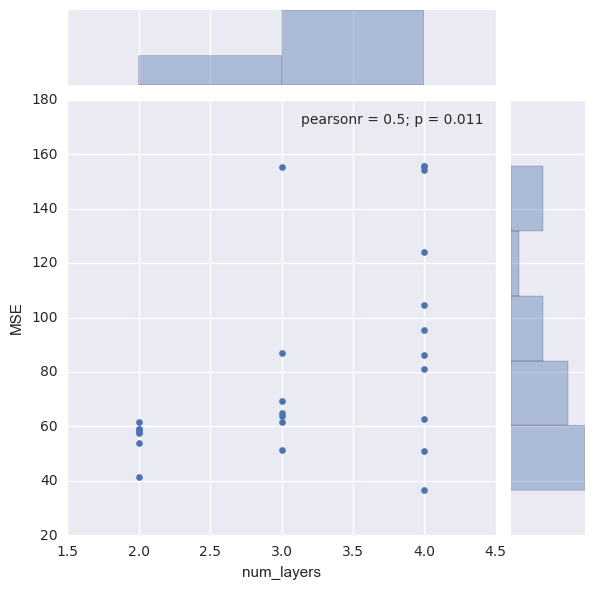

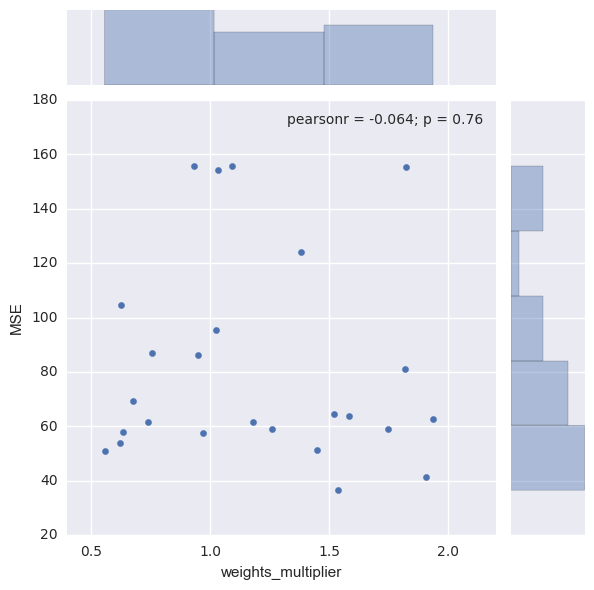

In [58]:
# Plot each feature with MSE to see the distribution and correlation
for feature in results_df:
    if feature == "MSE":
        continue
    elif feature == "activation_function":
        sns.stripplot(x=feature, y="MSE", data=results_df)
    else:
        sns.jointplot(x=feature, y="MSE", data=results_df)

Some notes about these results:
- On average, ReLU was the best activation function
- Larger batch size typically leads to lower MSE
- dropout_rate's value is insignificant
- Initial learning rate is not too important, but lower looks to be a bit better
- learning_rate_decay's value is not too important
- A great number of max nodes per layer looks to be better
- Initializing the model with more nodes is better
- The fewer layers, the better
- weights_multiplier's value is insignificant

In [99]:
best_models = [] # contains the log_strings of the best iterations, to be used for the final predictions
best_R2 = 0 # records the best R2 score
best_predictions = pd.DataFrame([0]*len(trainFinal)) # records the best predictions for each row
current_model = 1 # Used to equally weight the predictions from each iteration
testing_limit = 3 # If 3 consectutive iterations do not improve the best R2, stop predicting 

for model, result in sorted_results:
    checkpoint = str(model) + ".ckpt" 
    
    _, _, weights_multiplier, n_inputs, num_layers, _, _, max_nodes, activation_function = find_inputs(model)
    
    model = build_graph(num_layers,n_inputs,weights_multiplier,dropout_rate,
                        learning_rate,max_nodes,activation_function)
    
    # Predict one row at a time
    batch_size = 1

    with tf.Session() as sess:
        saver = tf.train.Saver()
        saver.restore(sess, checkpoint)
        predictions = [] # record the predictions

        for batch in range(int(len(trainFinal)/batch_size)):
            batch_x = trainFinal[batch*batch_size:(1+batch)*batch_size]

            batch_predictions = sess.run([model.preds],
                                   {model.inputs: batch_x,
                                    model.learning_rate: learning_rate,
                                    model.dropout_rate: 0,
                                    model.is_training: False})

            for prediction in batch_predictions[0]:
                predictions.append(prediction)
                
    predictions = pd.DataFrame(predictions)
    
    R2 = r2_score(y, predictions)
    print("R2 Score = ", R2)
    
    # Equally weight each prediction
    combined_predictions = (best_predictions*(current_model-1) + predictions) / current_model
    
    # Find the r2 score with the new predictions
    new_R2 = r2_score(y, combined_predictions)
    print("New R2 score = ", new_R2)
    
    if new_R2 >= best_R2:
        best_predictions = combined_predictions
        best_R2 = new_R2
        best_models.append(checkpoint)
        limit = 0
        current_model += 1
        print("Improvement!")
        print()
    else:
        print("No improvement.")
        limit += 1
        if limit == testing_limit:
            print("Stopping predictions.")
            break 

INFO:tensorflow:Restoring parameters from LR=0.005840267131929186,LRD=0.14082454856597507,WM=1.5361826721414689,NI=430,NL=4,DR=0.054051449749197865,BS=128,MN=1024,AF=tf.nn.relu.ckpt
R2 Score =  0.685801118804
New R2 score =  0.685801118804
Improvement!

INFO:tensorflow:Restoring parameters from LR=0.041184986691893334,LRD=0.21429242223480213,WM=1.9064544099142693,NI=783,NL=2,DR=0.24276008841339747,BS=128,MN=2048,AF=tf.nn.sigmoid.ckpt
R2 Score =  0.700375133011
New R2 score =  0.713749207155
Improvement!

INFO:tensorflow:Restoring parameters from LR=0.006892410825573677,LRD=0.2781085745981028,WM=0.5565297521242784,NI=964,NL=4,DR=0.2538243587355535,BS=256,MN=2048,AF=tf.nn.elu.ckpt
R2 Score =  0.640768569212
New R2 score =  0.69702594262
No improvement.
INFO:tensorflow:Restoring parameters from LR=0.07979152522458025,LRD=0.31427221646808645,WM=1.4500285499855532,NI=922,NL=3,DR=0.042109137349403566,BS=256,MN=32,AF=tf.nn.elu.ckpt
R2 Score =  0.617822941767
New R2 score =  0.696163025485
No 

In [100]:
# Take a look at the models that achieved the best R2 scores
best_models

['LR=0.005840267131929186,LRD=0.14082454856597507,WM=1.5361826721414689,NI=430,NL=4,DR=0.054051449749197865,BS=128,MN=1024,AF=tf.nn.relu.ckpt',
 'LR=0.041184986691893334,LRD=0.21429242223480213,WM=1.9064544099142693,NI=783,NL=2,DR=0.24276008841339747,BS=128,MN=2048,AF=tf.nn.sigmoid.ckpt']

## Making Predictions

In [101]:
best_predictions = pd.DataFrame([0]*len(testFinal))
current_model = 1

for model in best_models:
    checkpoint = model
    
    _, _, weights_multiplier, n_inputs, num_layers, _, _, max_nodes, activation_function = find_inputs(model)
    
    # Remove '.ckpt' from the activation_function string
    activation_function = activation_function[:activation_function.find('.ckpt')]
    
    model = build_graph(num_layers,n_inputs,weights_multiplier,dropout_rate,
                        learning_rate,max_nodes,activation_function)

    batch_size = 1

    with tf.Session() as sess:
        saver = tf.train.Saver()
        saver.restore(sess, checkpoint)
        predictions = []

        for batch in range(int(len(testFinal)/batch_size)):
            batch_x = testFinal[batch*batch_size:(1+batch)*batch_size]

            batch_predictions = sess.run([model.preds],
                                   {model.inputs: batch_x,
                                    model.learning_rate: learning_rate,
                                    model.dropout_rate: 0,
                                    model.is_training: False})

            for prediction in batch_predictions[0]:
                predictions.append(prediction)
                
    predictions = pd.DataFrame(predictions)
    
    combined_predictions = (best_predictions*(current_model-1) + predictions) / current_model
    best_predictions = combined_predictions
    current_model += 1

INFO:tensorflow:Restoring parameters from LR=0.005840267131929186,LRD=0.14082454856597507,WM=1.5361826721414689,NI=430,NL=4,DR=0.054051449749197865,BS=128,MN=1024,AF=tf.nn.relu.ckpt
INFO:tensorflow:Restoring parameters from LR=0.041184986691893334,LRD=0.21429242223480213,WM=1.9064544099142693,NI=783,NL=2,DR=0.24276008841339747,BS=128,MN=2048,AF=tf.nn.sigmoid.ckpt


In [118]:
# Prepare the dataframe for submitting to Kaggle
best_predictions['ID'] = test.ID
best_predictions['y'] = best_predictions[0]
best_predictions = best_predictions.drop([0],1)

best_predictions.to_csv("submission.csv", index=False)

In [103]:
best_predictions.head()

,ID,y
0,1,80.422852
1,2,97.269726
2,3,84.294689
3,4,78.183403
4,5,108.169102


In [104]:
# Compare distribution of the predictions with original target values (yFinal)
best_predictions.describe()

,ID,y
count,4209.000000,4209.000000
mean,4211.039202,100.349492
std,2423.078926,9.870055
min,1.000000,71.432465
25%,2115.000000,92.854492
50%,4202.000000,97.760437
75%,6310.000000,109.525723
max,8416.000000,136.106323


In [105]:
yFinal.describe()

,y
count,4208.000000
mean,100.630190
std,12.424146
min,72.110000
25%,90.817500
50%,99.150000
75%,109.010000
max,169.910000


## Summary

This models performs rather well and it would be interesting to add other algorithms, such as RandomForest and XGBoost, to the ensemble. Given the limited amount of data that we are working with, these other algorithms could improve the quality of the preditions. Nonetheless, this network (using 250 iterations) achieved an R2 score of 0.54403. The winning score was 0.55551 and the "Average Time Benchmark" score was -0.00169. I'm pleased with how well my random search experimentation worked and I'm looking forward to trying this method again.